In [2]:
import pandas as pd

# 6.4GB CSV 읽는 대신, 압축된 Parquet 파일을 10초 만에 로드
df_master = pd.read_parquet("df_master_preprocessed.parquet")

# CSV를 읽었을 때와 똑같이 DataFrame으로 보여짐
print(df_master.head())

print("\n--- Reviews DataFrame Info (Data Types) ---")
df_master.info()

   beer_id         username        date  \
0   271781     bluejacket74  2017-03-17   
1   125646          _dirty_  2017-12-21   
2   125646  GratefulBeerGuy  2017-12-20   
3   125646         LukeGude  2017-12-20   
4   125646          jneff33  2017-12-20   

                                                text  look  smell  taste  \
0     750 ml bottle, 2016 vintage, bottle #304 of...  4.00   4.00   4.00   
1                                                     4.50   4.50   4.50   
2     0% 16 oz can. Funny story: As I finally wal...  4.75   4.75   4.50   
3     Classic TH NEIPA. Overflowing head and bouq...  4.25   4.50   4.25   
4                                                     4.50   4.75   5.00   

   feel  overall  score  ...           availability   abv  \
0  4.25     4.00   4.03  ...  Limited (brewed once)  10.8   
1  4.50     4.50   4.50  ...               Rotating   8.2   
2  4.50     4.50   4.58  ...               Rotating   8.2   
3  4.25     4.25   4.31  ...            

In [3]:
# --- 2. 날짜 전처리 및 필터링 (핵심) ---
print("\nFiltering data for years 2013 and 2017...")

# 2-1. 'date' 컬럼(object)을 datetime 객체로 변환합니다.
#      errors='coerce'는 변환 중 오류가 발생하는 날짜(예: 'Unknown')를 NaT(결측치)로 만듭니다.
df_master['datetime'] = pd.to_datetime(df_master['date'], errors='coerce')

# 2-2. 'datetime' 컬럼에서 'year'를 추출하여 새 컬럼을 만듭니다.
df_master['year'] = df_master['datetime'].dt.year

# 2-3. (선택) 날짜 변환 후 결측치(NaT)가 있는지 확인합니다.
original_rows = df_master.shape[0]
df_master = df_master.dropna(subset=['year']) # 날짜를 알 수 없는 리뷰는 제거
new_rows = df_master.shape[0]
print(f"Removed {original_rows - new_rows} rows with invalid dates.")

# 2-4. 'year' 컬럼이 2013 또는 2017인 행만 선택합니다.
years_to_keep = [2013, 2017]
df_filtered = df_master[df_master['year'].isin(years_to_keep)].copy()

# 2-5. (선택) 메모리 확보를 위해 더 이상 필요 없는 컬럼을 제거합니다.
df_filtered = df_filtered.drop(columns=['datetime', 'date', 'text', 'notes_beer', 'notes_brewery'])

# --- 3. 결과 확인 ---
print(f"\nFiltering complete.")
print(f"Original shape: {df_master.shape} (모든 연도)")
print(f"Filtered shape: {df_filtered.shape} (2013, 2017년만)")
print("\nFiltered data 'year' counts:")
print(df_filtered['year'].value_counts())

# --- 4. (다음 단계) ---
# 이제 'df_filtered'를 사용하여 CF, Hybrid 모델 등을 구축합니다.
# X = df_filtered.drop(columns=['score', 'is_like'])
# y = df_filtered['score']


Filtering data for years 2013 and 2017...
Removed 0 rows with invalid dates.

Filtering complete.
Original shape: (8417033, 28) (모든 연도)
Filtered shape: (1863769, 23) (2013, 2017년만)

Filtered data 'year' counts:
year
2013    1267028
2017     596741
Name: count, dtype: int64



Filtering data for years 2013 and 2017...
Filtered data shape (2013, 2017): (1863769, 28)

Calculating user-level score statistics (mean, max, min)...

--- Descriptive Statistics of User Scores (Sampled Data) ---
       user_mean_score  user_max_score  user_min_score
count     24540.000000    24540.000000    24540.000000
mean          3.997245        4.704700        2.829724
std           0.431203        0.403291        1.023701
min           1.000000        1.000000        1.000000
10%           3.502850        4.250000        1.250000
25%           3.775000        4.510000        2.000000
50%           4.008620        4.750000        3.000000
75%           4.253672        5.000000        3.570000
90%           4.500000        5.000000        4.160000
99%           4.990000        5.000000        4.970000
max           5.000000        5.000000        5.000000

--- Descriptive Statistics of User Score *Range* (for users with >1 review) ---
       range_above_mean  range_below_mean
cou

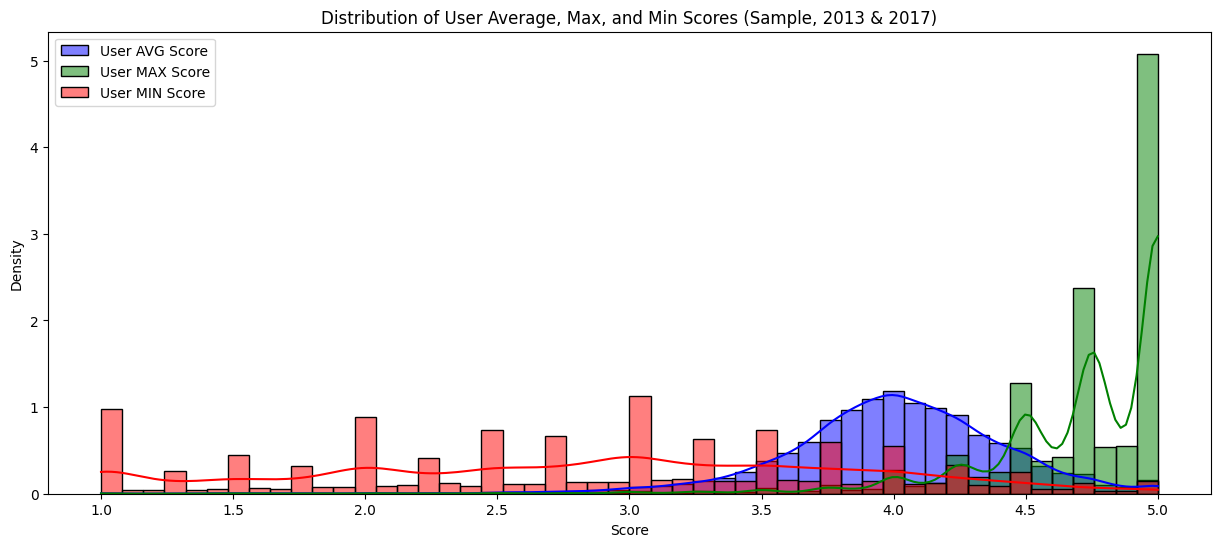

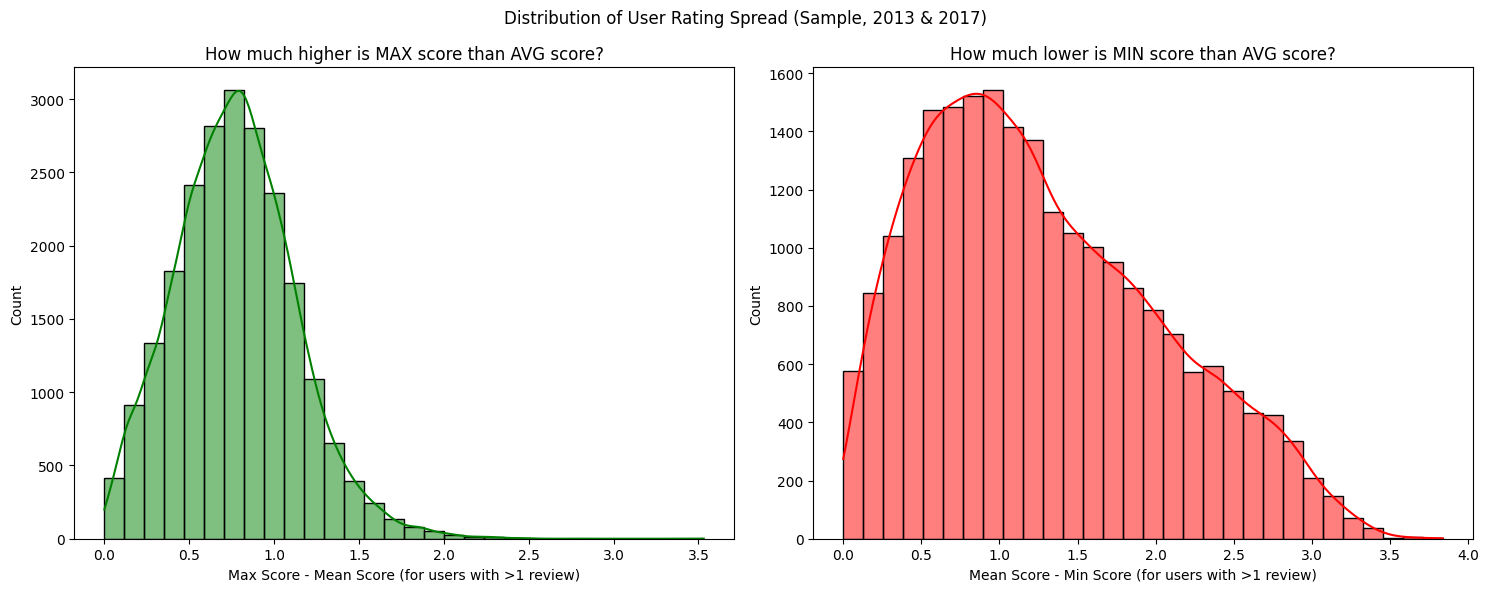

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


if df_master is not None:
    # --- 2. 2013년, 2017년 데이터 필터링 ---
    print("\nFiltering data for years 2013 and 2017...")
    df_master['datetime'] = pd.to_datetime(df_master['date'], errors='coerce')
    df_master['year'] = df_master['datetime'].dt.year
    df_master = df_master.dropna(subset=['year']) # 유효하지 않은 날짜 제거
    
    years_to_keep = [2013, 2017]
    df_filtered = df_master[df_master['year'].isin(years_to_keep)].copy()
    
    if df_filtered.empty:
        print("Warning: No data found for 2013 or 2017 in the sample.")
    else:
        print(f"Filtered data shape (2013, 2017): {df_filtered.shape}")

        # --- 3. 유저별 통계 계산 ---
        print("\nCalculating user-level score statistics (mean, max, min)...")
        user_stats = df_filtered.groupby('username')['score'].agg(
            user_mean_score='mean',
            user_max_score='max',
            user_min_score='min',
            user_review_count='count'
        ).reset_index()

        # --- 4. 통계 분석 ---
        print("\n--- Descriptive Statistics of User Scores (Sampled Data) ---")
        print(user_stats[['user_mean_score', 'user_max_score', 'user_min_score']].describe(percentiles=[.1, .25, .5, .75, .9, .99]))

        # 유저별 "평점 범위(Spread)" 계산
        user_stats['range_above_mean'] = user_stats['user_max_score'] - user_stats['user_mean_score']
        user_stats['range_below_mean'] = user_stats['user_mean_score'] - user_stats['user_min_score']
        
        user_stats_multi_review = user_stats[user_stats['user_review_count'] > 1]

        if user_stats_multi_review.empty:
            print("No users with more than 1 review found in the filtered sample. Skipping spread analysis.")
        else:
            print("\n--- Descriptive Statistics of User Score *Range* (for users with >1 review) ---")
            print(user_stats_multi_review[['range_above_mean', 'range_below_mean']].describe(percentiles=[.1, .25, .5, .75, .9, .99]))

            # --- 5. 분포 시각화 ---
            
            # Plot 1: 유저별 평균, 최고, 최저 점수 분포
            plt.figure(figsize=(15, 6))
            sns.histplot(user_stats['user_mean_score'], color='blue', label='User AVG Score', kde=True, stat='density', common_norm=False, bins=50)
            sns.histplot(user_stats['user_max_score'], color='green', label='User MAX Score', kde=True, stat='density', common_norm=False, bins=50)
            sns.histplot(user_stats['user_min_score'], color='red', label='User MIN Score', kde=True, stat='density', common_norm=False, bins=50)
            plt.title('Distribution of User Average, Max, and Min Scores (Sample, 2013 & 2017)')
            plt.xlabel('Score')
            plt.legend()
            plt.savefig('user_score_distributions_sample.png')
            print("\nSaved 'user_score_distributions_sample.png'")

            # Plot 2: 유저의 평점 범위 (Spread) 분포
            plt.figure(figsize=(15, 6))
            
            plt.subplot(1, 2, 1)
            sns.histplot(user_stats_multi_review[user_stats_multi_review['range_above_mean'] > 0]['range_above_mean'], color='green', kde=True, bins=30)
            plt.title('How much higher is MAX score than AVG score?')
            plt.xlabel('Max Score - Mean Score (for users with >1 review)')
            
            plt.subplot(1, 2, 2)
            sns.histplot(user_stats_multi_review[user_stats_multi_review['range_below_mean'] > 0]['range_below_mean'], color='red', kde=True, bins=30)
            plt.title('How much lower is MIN score than AVG score?')
            plt.xlabel('Mean Score - Min Score (for users with >1 review)')
            
            plt.suptitle('Distribution of User Rating Spread (Sample, 2013 & 2017)')
            plt.tight_layout()
            plt.savefig('user_score_spread_distribution_sample.png')
            print("Saved 'user_score_spread_distribution_sample.png'")

    print("\nAnalysis complete.")

In [3]:
# (위 3단계 user_stats 계산이 끝난 후 실행)

# 1. user_stats를 df_filtered에 다시 병합하여 각 리뷰 행에 유저의 평균 점수를 붙여줍니다.
df_model_data = pd.merge(
    df_filtered, 
    user_stats[['username', 'user_mean_score', 'user_review_count']], 
    on='username', 
    how='left'
)

# 2. (추천) Threshold 정의: "평균보다 0.5점 높은 점수"
#    이 값은 유저의 '진짜 선호'를 의미합니다.
THRESHOLD = 0.5 

# 3. 새로운 Target(y) 생성: 'is_top_pick' (1 = Top Pick, 0 = 그 외)
#    (score가 user_mean_score + 0.5보다 높으면 1, 아니면 0)
df_model_data['is_top_pick'] = (
    df_model_data['score'] > (df_model_data['user_mean_score'] + THRESHOLD)
).astype(int)

# (선택) 비선호(Low Pick) 피처도 생성
df_model_data['is_low_pick'] = (
    df_model_data['score'] < (df_model_data['user_mean_score'] - THRESHOLD)
).astype(int)


# 4. 결과 확인
print("\n'is_top_pick' (y) 생성 결과:")
print(df_model_data['is_top_pick'].value_counts(normalize=True))

# 5. Hybrid 모델(XGBoost) 학습 시, y로 'is_like' 대신 'is_top_pick'을 사용합니다.
# y_target = df_model_data['is_top_pick'] 
# model = XGBClassifier()
# model.fit(X_features, y_target)


'is_top_pick' (y) 생성 결과:
is_top_pick
0    0.866971
1    0.133029
Name: proportion, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import dask_ml.cluster
import dask_ml.preprocessing
from dask_ml.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import dask.distributed
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# --- 0. Dask 클러스터 시작 (핵심!) ---
# 이것이 Jupyter Notebook 내에서 "분산 처리"를 활성화하는 코드입니다.
# 모든 CPU 코어를 사용하여 병렬로 작업을 처리합니다.
try:
    client = dask.distributed.Client()
    print(f"Dask 클러스터(Scheduler)가 시작되었습니다: {client.dashboard_link}")
except Exception as e:
    print(f"Dask 클러스터 시작 실패: {e}. 로컬 스레드로 진행합니다.")

# --- 하이퍼파라미터 ---
SAMPLE_FRAC = 0.2 # (조정 가능) 840만 행의 20% (약 170만 행)을 샘플링
K_BEERS = 6
K_USERS = 8
THRESHOLD = 0.5   # 'Top Pick' 정의 (평균보다 +0.5점)

# --- 1. Dask로 로드, 필터링, 샘플링 ---
print(f"\n--- 1. 데이터 로드, 필터링, 샘플링 (FRAC={SAMPLE_FRAC}) ---")
# Dask는 파일을 메모리에 올리지 않고 "읽을 준비"만 합니다.
try:
    ddf_master = dd.read_parquet('df_master_preprocessed.parquet')
except Exception as e:
    print(f"Parquet 로드 실패: {e}. 'reviews.csv'에서 Dask로 읽기를 시도합니다.")
    # (필요한 컬럼만 Dask로 읽기)
    ddf_master = dd.read_csv(
        'reviews.csv', 
        usecols=['username', 'date', 'score', 'beer_id', 'smell', 'taste', 'feel', 'abv', 'style', 'country_brewery']
        # (실제로는 beer/breweries 병합이 필요하지만, 여기서는 리뷰 파일만 가정)
        # (이 코드는 EDA 노트북의 피처(style_group, geo_group)가 없으므로 데모용입니다.)
    )

# 1-1. 2013, 2017년 필터링 (Dask 문법)
ddf_master['datetime'] = dd.to_datetime(ddf_master['date'], errors='coerce')
ddf_master['year'] = ddf_master['datetime'].dt.year
ddf_filtered = ddf_master[ddf_master['year'].isin([2013, 2017])].copy()

# 1-2. (중요) 샘플링
ddf_sample = ddf_filtered.sample(frac=SAMPLE_FRAC, random_state=42)

# 1-3. (중요) Dask 메모리 최적화
# .persist()는 지금까지의 계산(필터링, 샘플링)을 실행하고, 
# 그 결과(170만 행)를 메모리(및 디스크)에 "고정"시켜 다음 groupby/merge가 빨라지게 함
print("Dask 데이터 필터링 및 샘플링 실행 중...")
ddf_sample = ddf_sample.persist()
print(f"샘플링 완료. 최종 학습 데이터 크기: {len(ddf_sample)} 행")


# (EDA 노트북의 style_group, geo_group이 없다고 가정하고 Dask로 재생성)
def group_style(style):
    if 'IPA' in str(style): return 'IPA'
    if 'Stout' in str(style): return 'Stout'
    if 'Ale' in str(style): return 'Ale'
    return 'Other'
ddf_sample['style_group'] = ddf_sample['style'].apply(group_style, meta=('style', 'object'))

def group_country(country):
    if country == 'US': return 'US'
    if country in ['DE', 'GB', 'BE']: return 'Europe'
    return 'Other'
ddf_sample['geo_group'] = ddf_sample['country_brewery'].apply(group_country, meta=('country_brewery', 'object'))


# --- 2. Dask로 Beer 클러스터링 (새로 생성) ---
print(f"\n--- 2. Dask Beer 클러스터링 (K={K_BEERS}) ---")
beer_features_df = ddf_sample[['beer_id', 'style_group', 'geo_group', 'abv']].drop_duplicates(subset=['beer_id'])
beer_features_df = beer_features_df.dropna().persist()

# (Dask는 OHE보다 LabelEncoding 후 K-Means가 더 안정적일 수 있음)
# (간단하게 Dask-ML의 K-Means는 숫자형만 받으므로 OHE 대신 수치 변환)
beer_features_df['style_group'] = beer_features_df['style_group'].astype('category').cat.codes
beer_features_df['geo_group'] = beer_features_df['geo_group'].astype('category').cat.codes

kmeans_beer = dask_ml.cluster.KMeans(n_clusters=K_BEERS, random_state=42)
scaler_beer = dask_ml.preprocessing.StandardScaler()
beer_features_processed = scaler_beer.fit_transform(beer_features_df[['abv', 'style_group', 'geo_group']])
print("Beer K-Means 학습 중...")
beer_features_df['beer_cluster'] = kmeans_beer.fit_predict(beer_features_processed)


# --- 3. Dask로 User 클러스터링 (새로 생성) ---
print(f"\n--- 3. Dask User 클러스터링 (K={K_USERS}) ---")
# (Dask로 취향 벡터 생성 - dask.dataframe.pivot_table 사용)
user_style_affinity = ddf_sample.pivot_table(index='username', columns='style_group', values='score', aggfunc='count').fillna(0)
# (비율로 변환)
user_style_affinity = user_style_affinity.div(user_style_affinity.sum(axis=1), axis=0).fillna(0)

user_numeric_features = ddf_sample.groupby('username').agg(
    user_avg_score=('score', 'mean'),
    user_avg_abv=('abv', 'mean'),
    user_avg_smell=('smell', 'mean')
).fillna(0)

user_profile_df = dd.concat([user_numeric_features, user_style_affinity], axis=1).fillna(0).persist()

kmeans_user = dask_ml.cluster.KMeans(n_clusters=K_USERS, random_state=42)
scaler_user = dask_ml.preprocessing.StandardScaler()
user_features_processed = scaler_user.fit_transform(user_profile_df)
print("User K-Means 학습 중...")
user_profile_df['user_cluster'] = kmeans_user.fit_predict(user_features_processed)


# --- 4. 최종 학습 데이터셋 생성 (Dask Merge & Target) ---
print("\n--- 4. 최종 학습 데이터셋 생성 ---")
df_model = dd.merge(ddf_sample, beer_features_df[['beer_cluster']], on='beer_id', how='left')
df_model = dd.merge(df_model, user_profile_df[['user_cluster', 'user_mean_score']], on='username', how='left')

df_model['is_top_pick'] = (df_model['score'] > (df_model['user_mean_score'] + THRESHOLD)).astype(int)
df_model = df_model.dropna().persist()
print(f"Dask 모델 데이터 준비 완료 (메모리 고정).")


# --- 5. Train / Test / Validation 분리 (Dask-ML) ---
print("\n--- 5. Dask Train/Test/Validation 분리 ---")
features_to_use = [
    'abv', 'smell', 'taste', 'feel',
    'style_group', 'geo_group',
    'beer_cluster', 'user_cluster'
]
target = 'is_top_pick'

X = df_model[features_to_use]
y = df_model[target]

# (중요) Dask-XGBoost는 'category' Dtype을 인식합니다. (OHE/LabelEncoder 불필요)
for col in ['style_group', 'geo_group', 'beer_cluster', 'user_cluster']:
    X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# --- 6. "아이언맨" (Dask-XGBoost Hybrid) 모델 학습 ---
print("\n--- 6. Dask-XGBoost Hybrid 모델 학습 시작 ---")
# Dask 전용 XGBoost 분류기
hybrid_model_xgb = xgb.dask.DaskXGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=500, # (Early stopping으로 최적화됨)
    learning_rate=0.05,
    max_depth=6,
    n_jobs=-1,
    random_state=42,
    enable_categorical=True # (★중요★) 'category' Dtype을 자동으로 처리
)

# 학습 (Dask는 .compute() 전까지 실제 계산을 안 함)
print("XGBoost 학습 계획 수립 중...")
hybrid_model_xgb.fit(
    X_train_sub, 
    y_train_sub,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=30,
    verbose=100
)

# --- 7. 모델 평가 (Test Set) ---
print("\n--- 7. 모델 평가 (Test Set) ---")
# .compute()를 호출하는 순간, Dask가 전체 파이프라인(로드,클러스터링,학습,예측)을 실행합니다.
print("최종 평가를 위해 Dask 작업 그래프 실행 중...")
preds_proba = hybrid_model_xgb.predict_proba(X_test)[:, 1].compute()
preds_binary = hybrid_model_xgb.predict(X_test).compute()
y_test_computed = y_test.compute()

# 평가
auc_score = roc_auc_score(y_test_computed, preds_proba)
accuracy = accuracy_score(y_test_computed, preds_binary)

print(f"\n[Hybrid Model - Test Set 결과]")
print(f"AUC (Area Under Curve): {auc_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_computed, preds_binary))

print("\nDask Hybrid (XGBoost) 모델 파이프라인 완료.")

# --- 8. Dask 클러스터 종료 ---
client.close()